In [1]:
from mmdet.apis import init_detector, inference_detector, show_result, show_result_pyplot
import mmcv
import os
import numpy as np
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import pylab
import skimage.io as io
import json
from pycocotools.coco import COCO
import re

In [2]:
def json_parser(anno_root):
    with open(anno_root) as f:
        data = json.load(f)
    
    # info = data['info']
    # licenses = data['licenses']
    
    '''
        print(data.keys()) 
        return: dict_keys(['images', 'annotations', 'categories'])
    '''
    category = [c['name'] for c in data['categories']] # return ship
    category_dict = {c['id']: c['name'] for c in data['categories']}
    # category_dict : {1: 'ship'}
    max_category_id = max(category_dict.keys())
    
    annotations = data['annotations']
    images = data['images']
    
    # id to image mapping
    image_dict = {}
    img_list = list()
    
    for image in images:
        key = image['id']
        image_dict[key] = [image['file_name'], image['width'], image['height']]
        img_list.append(image['file_name'])
        
    category_count = [0 for _ in range(max_category_id)]
    
    total_annotations = {}
    
    for a in annotations:
        image_name = image_dict[a["image_id"]][0].replace('.jpg', '')
        width = image_dict[a["image_id"]][1]
        height = image_dict[a["image_id"]][2]
        idx = a['category_id']
        single_ann = []
        single_ann.append(category_dict[idx])
        single_ann.extend(list(map(int, a['bbox'])))
        single_ann.extend([width, height])
        
        if image_name not in total_annotations:
            total_annotations[image_name] = []
        
        category_count[idx - 1] += 1
        total_annotations[image_name].append(single_ann)
    
    print('\n==============[ COCO json info ]==============')
    print("Total Annotations: {}".format(len(annotations)))
    print("Total Image      : {}".format(len(images)))
    print("Annotated Image  : {}".format(len(total_annotations)))
    print("Total Category   : {}".format(len(category)))
    
    for c, cnt in zip(category, category_count):
        if cnt != 0:
            print("{:^20}| {}".format(c, cnt))
    print()
    
    return category, img_list, total_annotations

def get_singleImg_gt(name, total_annotations):
    if name.replace('.jpg', '') not in total_annotations.keys():
        print('There are no annotations in %s.' % name)
        return []
    else:
        return total_annotations[name.replace('.jpg', '')]

def draw_gt_boxes(img, objs):
    
    img = cv2.imread(img)
    
    for obj in objs:
        box = obj[1:]
        xmin = max(box[0], 0)
        ymin = max(box[1], 0)
        xmax = min(box[0] + box[2], obj[5])
        ymax = min(box[1] + box[3], obj[6])
        
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,0,225), 1)
    
    cv2.imwrite('2.jpg', img)

In [4]:
# COCO json path
annFile = '/home/user/mmdetection-1.2.0/data/sar_coco_form/HRSID/annotations/train_test2017.json'

In [5]:
category, img_list, total_annotations = json_parser(annFile)


==============[ COCO json info ]==============
Total Annotations: 16951
Total Image      : 5604
Annotated Image  : 5604
Total Category   : 1
        ship        | 16951



In [7]:
config_file = '../configs/SSDD/faster_rcnn_r50_fpn_1x.py'
# download the checkpoint from model zoo and put it in `checkpoints/`
checkpoint_file = '../sar_work_dirs/HRSID/faster_rcnn_r50_fpn_1x_baseline(scale=4)/latest.pth'
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [22]:
img = 'P0120_3600_4400_9000_9800.jpg'

In [23]:
result, x_backbone, x_fpn = inference_detector(model, img)
# show the results
show_result(img, result, model.CLASSES, score_thr=0.8, out_file='1.jpg')

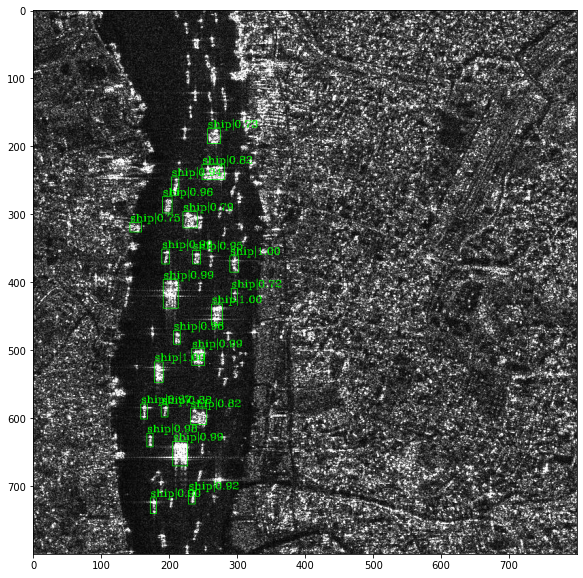

In [24]:
show_result_pyplot(img, result, model.CLASSES, score_thr=0.7)

In [26]:
bboxes = get_singleImg_gt(img, total_annotations)

In [27]:
draw_gt_boxes(img, bboxes)